# Sleep study for spindle detection
# Preprocess

## Imports
Import necessary libraries and modules.

In [21]:
import warnings
warnings.filterwarnings("ignore")
import mne
import utils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import detrend
from scipy import signal
import sklearn.preprocessing as preprocess
import vmdpy
import pickle

## Data Loading and Initial Processing
Load and preprocess the EEG data.

In [22]:

def load_data(file_path, labels_path):
    raw_mat = utils.load_eeg_data(file_path)
    raw = utils.mk_raw_obj(raw_mat)
    raw_data = raw.get_data()
    labels = pd.read_csv(labels_path)
    labels.sort_values("Timestamp", inplace=True)
    return raw, raw_data, labels

raw, raw_data, labels = load_data("/dataset/train_S002_night1_hackathon_raw.mat", "/dataset/train_S002_labeled.csv")
    

Creating RawArray with float64 data, n_channels=1, n_times=4965399
    Range : 0 ... 4965398 =      0.000 ... 19861.592 secs
Ready.


## Data Detrending
Detrend the EEG data to remove linear trends.

In [23]:

def detrend_array(raw_data):
    detrended_data = detrend(raw_data)
    info = mne.create_info(ch_names=['EEG0'], sfreq=250, ch_types='eeg')
    detrended_raw = mne.io.RawArray(detrended_data, info)
    return detrended_raw, detrended_data

detrend_raw, detrend_data = detrend_array(raw_data)

Creating RawArray with float64 data, n_channels=1, n_times=4965399
    Range : 0 ... 4965398 =      0.000 ... 19861.592 secs
Ready.


## Statistical Analysis
Calculate and display statistics of the raw and detrended data.

In [24]:

def display_statistics(raw_data, detrend_data):
    statistics = {
        "Mean": [raw_data.mean(), detrend_data.mean()],
        "Std": [raw_data.std(), detrend_data.std()]
    }
    df = pd.DataFrame(statistics, index=["Raw", "Detrended"])
    print(df)

display_statistics(raw_data, detrend_data)
    

                   Mean         Std
Raw       -9.820040e-06  134.867859
Detrended -7.876159e-17  134.867859


## Power Spectral Density (PSD) Computation and Plotting
Compute and plot the PSD for both raw and detrended data.

Effective window size : 8.192 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


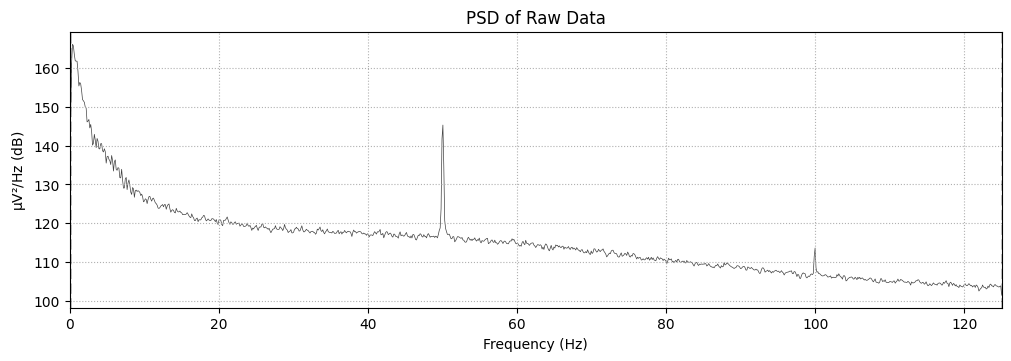

Effective window size : 8.192 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


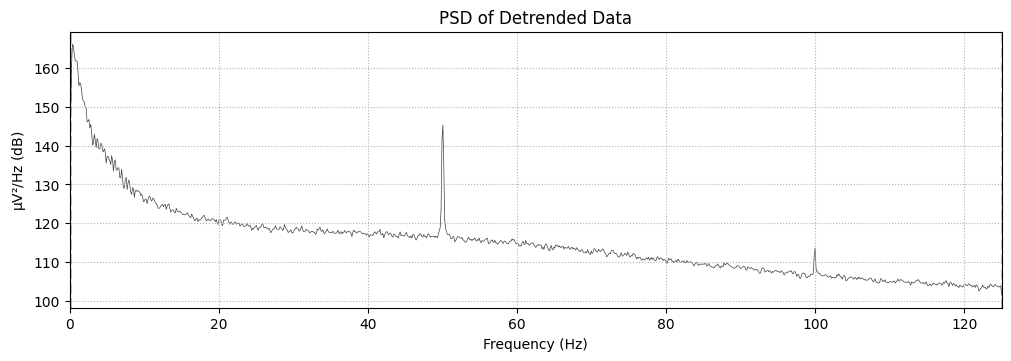

In [25]:
def plot_psd(raw, title):
    psd = raw.compute_psd()
    psd.plot()
    plt.title(title)
    plt.show()

plot_psd(raw, "PSD of Raw Data")
plot_psd(detrend_raw, "PSD of Detrended Data")
    

We can see that the data has not be majorly changed, the frequencies and amplitudes are still very similar. We have lowered the mean to be close to 0, this will be important to maintain the same baseline level accross all the recording.
There are two spikes in frequency around 50Hz and 100Hz, this won't be a problem since the frequencies where our study is focused are below 35-40Hz (alpha, beta, theta waves).
We will deal with the detrended raw data now.

## Epoch Creation and Artifact Detection

Since we are dealing with a single-channel EEG, a robust artifact identification is complicated. Most techniques use different channels as references to extract the signals corresponding to artifacts.
Nonetheless, the data will be explored to verify that the artifacts are not causing too much noise. The technique proposed is based on amplitude changes in each epoch.
Let's start by creating epochs of 30 seconds in our data:

In [26]:
def create_epochs(raw, duration):
    events = mne.make_fixed_length_events(raw, duration=duration)
    epochs = mne.Epochs(raw, 
                        events,
                        tmin=0, 
                        tmax=duration, 
                        baseline=None, 
                        preload=False)
    return epochs

def detect_amplitude_artifacts(epoch, threshold_factor=4):
    mean_amplitude = np.mean(epoch)
    std_dev_amplitude = np.std(epoch)
    upper_threshold = mean_amplitude + threshold_factor * std_dev_amplitude
    lower_threshold = mean_amplitude - threshold_factor * std_dev_amplitude
    artifact_indices = np.logical_or(epoch > upper_threshold, epoch < lower_threshold)

    return np.where(artifact_indices == 1)[0]

def get_artifact_times(epochs, epoch_duration, sfreq):
    artifact_times = np.empty(0, dtype=int)
    for i, epoch in enumerate(epochs):
        epoch_data = epoch[0]
        artifact_indices = detect_amplitude_artifacts(epoch_data, 5)
        adjusted_indices = artifact_indices + int(i * epoch_duration * sfreq)
        print(adjusted_indices)
        artifact_times = np.append(artifact_times, adjusted_indices)
    return artifact_times

In [27]:
%%capture
epoch_duration = 30
epochs = create_epochs(detrend_raw, epoch_duration)
artifact_times = get_artifact_times(epochs, epoch_duration, detrend_raw.info['sfreq'])
times = np.arange(detrend_data.size) / detrend_raw.info['sfreq']

In [28]:
print("Number of artifacts in time samples:", len(artifact_times))

Number of artifacts in time samples: 5200


*Let's make a plot to see the distribution of these artifacts*

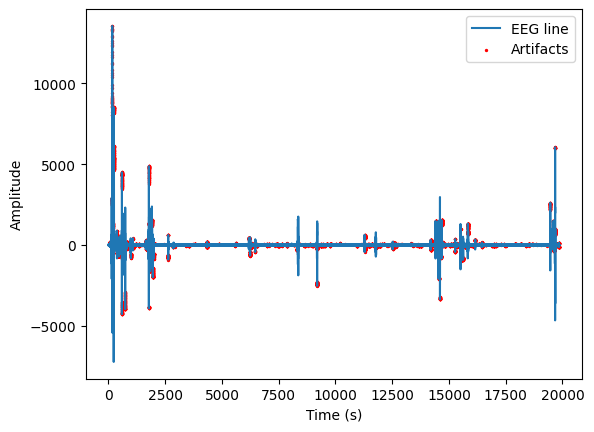

In [29]:
plt.plot(times, detrend_data[0], label='EEG line')

# Plot artifact markers
plt.scatter(times[artifact_times], detrend_data[0, artifact_times], color='red', label='Artifacts', s=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


The artefacts detection based on amplitude shows that they may be present in all the timeline of the analysis, the raw EEG will be explored to see if these artifacts match our sleep spindle events

#### Annotating EEG with artifacts and sleep spindles

In [30]:
def is_artifact_close(artifact, labels, threshold):
    for label in labels:
        if abs(artifact['onset'] - label['onset']) <= threshold:
            return True
    return False

def get_artifacts_annotations(raw, artifact_times, label_annotation, filter=False):
    artifact_annotation = mne.Annotations(onset=artifact_times,
                                          duration = [0.01] * len(artifact_times),
                                          description=['Art'] * len(artifact_times))
    if filter is True:
        filtered_artifacts = [art for art in artifact_annotation if is_artifact_close(art, label_annotation, 30)]
        artifact_annotation = mne.Annotations(onset=[ann['onset'] for ann in filtered_artifacts],
                                       duration=[ann['duration'] for ann in filtered_artifacts],
                                       description=[ann['description'] for ann in filtered_artifacts])
    return artifact_annotation

def get_annotations(labels, event_types = ['SS', 'K', 'REM', 'Son', 'Soff', 'A', 'MS']):
    annotations = mne.Annotations(onset=[], duration=[], description=[])
    
    for event in event_types:
        onsets = labels.loc[labels[event + '1'] == 1, 'Timestamp'] / 250
        durations = [2] * len(onsets)
        annotation = mne.Annotations(onset=onsets, duration=durations, description=event)
        annotations += annotation
    
    return annotations
    

In [31]:
%%capture
label_annotation = get_annotations(labels, ['SS'])
artifact_annotations = get_artifacts_annotations(detrend_raw, artifact_times, label_annotation,filter=True)
all_annotation = artifact_annotations + label_annotation
annotated_raw = detrend_raw.copy().set_annotations(all_annotation)
annotated_raw.save('ressources/plot_artifact_eeg.fif', overwrite=True)

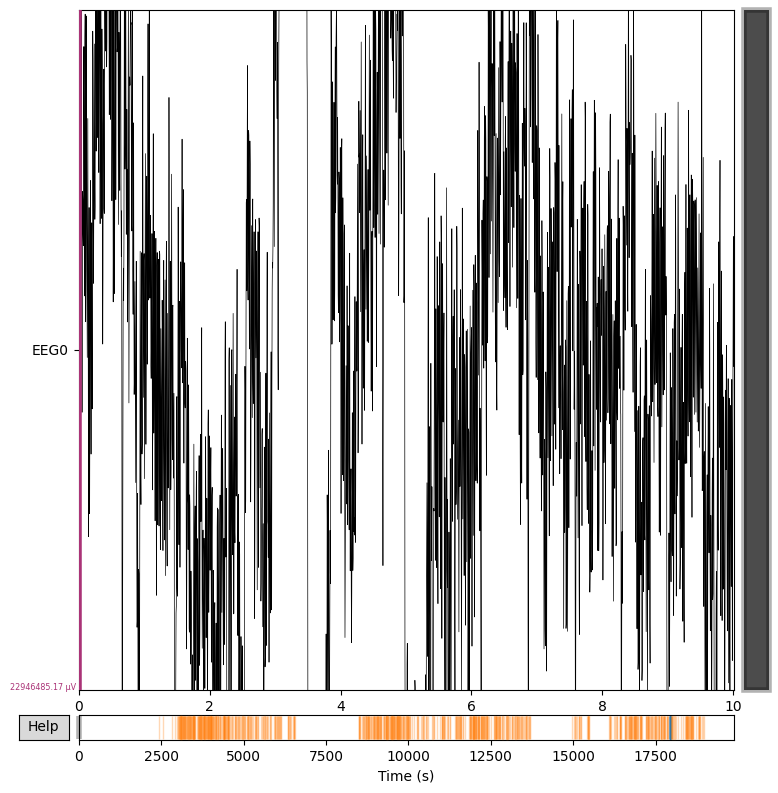

In [32]:
annotated_raw.plot(scalings='auto')
plt.show()

#### Extract Artifact with signal decomposition

We will try to eliminate the artifact using Variational Mode Decomposition (VMD) which shows great results in single-channel EEG. It's a signal processing method used to separate a multi-component signal into its constituent frequencies, aiding in artifact elimination and feature extraction. https://doi.org/10.3390/s22176698

As a VMD can be computationally intensive and requires several tests to establish the parameters.
- Data splitted into 5 parts
- Low complexity parameters
- Bandpass filter between 4-35 Hz, interesting frequencies for the study

In [33]:
def make_vdm(raw):
    num_modes = 3  # Number of components the raw data will be splitted into 
    alpha = 100   
    tau = 0.1    
    tol = 1e-3
    maxiter = 500
    raw.filter(4, 35, verbose=False)
    raw_split = np.array_split(raw.get_data()[0], 5)
    all_modes = []
    for k, split in enumerate(raw_split):
        modes = vmdpy.VMD(split, num_modes, alpha, tau, tol, maxiter)
        np.save(f'u_sub3_{k}.npy', modes[0])
        all_modes.append(modes)
        with open('all_u_sub3.pkl', 'wb') as f:
            pickle.dump(all_modes, f)

#### Exploring the decomposition of the VMD

For readability, only the first split is shown. The raw EEG will be plotted along its PSD, to show which frequencies are predominant in each decomposition

In [34]:
vmd_0 = np.load('ressources/vdm/u0.npy')
time_part1 = vmd_0.shape[1] // raw.info['sfreq']
raw_crop = raw.copy().crop(0, time_part1)

In [35]:
def plot_raw_and_psd(eeg_signal, axes, row, duration=200, label="VDM component", spectrum_label="PSD"):
    # Plot the eeg_signal
    axes[row, 0].plot(eeg_signal)
    axes[row, 0].set_title(f"{label} {row + 1}")

    # Compute and plot the power spectral density (PSD)
    freqs, psd = signal.welch(eeg_signal, 250)
    axes[row, 1].plot(freqs, psd)
    axes[row, 1].set_title(f"{spectrum_label} {row + 1}")

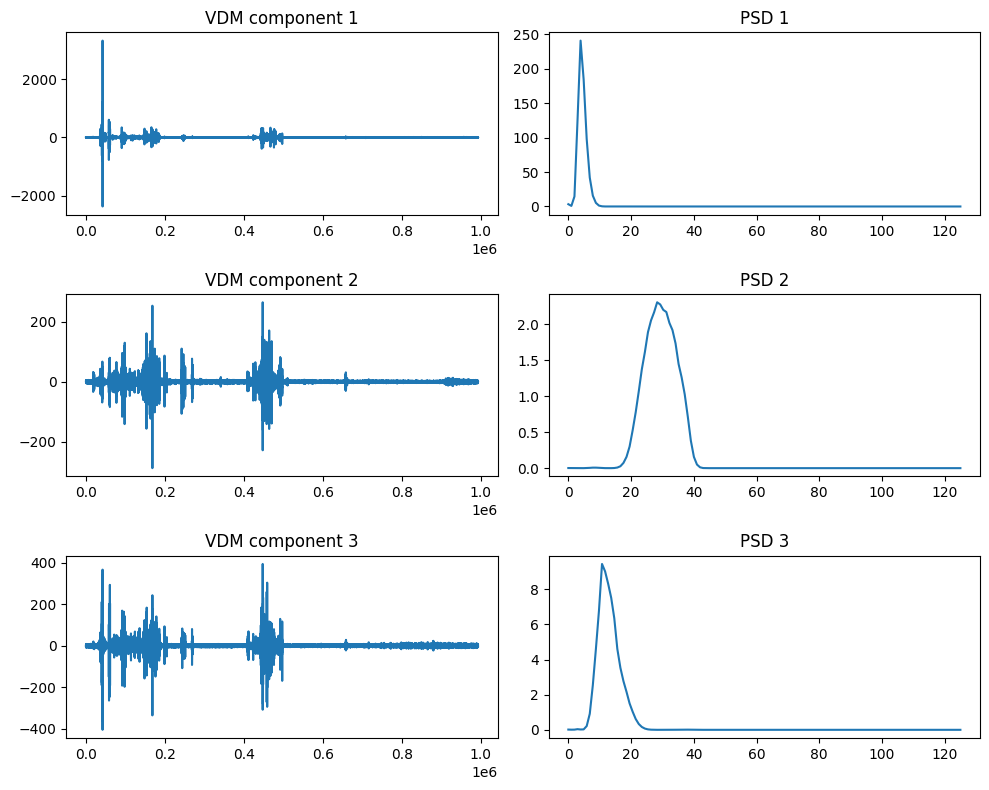

In [38]:
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Loop through each signal and plot
for i in range(len(vmd_0)):
    plot_raw_and_psd(vmd_0[i], axes, i)

plt.tight_layout()
plt.show()